# Бутстрап

Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках эксперимента

В полученных подвыборках считаются статистики (среднее, медиана и т.п)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительный интервал, а бутстрап это может сделать

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm import tqdm

plt.style.use('ggplot')

%config IPCompleter.greedy = True

In [3]:
df = pd.read_csv('/Users/askhabaliev/Desktop/analysis/hw_bootstrap.csv', sep=';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [4]:
control = pd.to_numeric(df[df.experimentVariant == "Control"].value.str.replace(',', '.'))
treatment = pd.to_numeric(df[df.experimentVariant == "Treatment"].value.str.replace(',', '.'))

In [5]:
def get_bootstrap(
    data_column_1, #данные первой метрики
    data_column_2, #данные второй метрики
    boot_it = 1000, #количество бутстрап-подвыборок
    statistic = np.mean, #интересующая нас статистика
    bootstrap_conf_level = 0.95 #уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)): #извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1 - samples_2)) #mean() - применяем статистику
    
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    #визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('boot_data')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data': boot_data, 'ci': ci, 'p_value': p_value}

In [6]:
# Будем пробовать бутстрап на эксп. распределении

np.random.seed(5)

100%|██████████| 1000/1000 [00:00<00:00, 3046.61it/s]


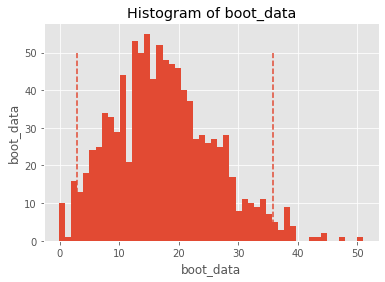

In [7]:
booted_data = get_bootstrap(treatment, control) # В результате хранится разница двух распределений, ДИ и pvalue

In [8]:
booted_data["ci"] # ДИ

,0
0.025,2.955072
0.975,35.859146


In [9]:
# p_value Бутстрепа

booted_data["p_value"] # Альфа

0.03965286258466567

In [10]:
# p_value U-критерия Манна-Уитни

stat, p = mannwhitneyu(treatment, control)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=124189.500, p=0.430


В бутстрапе для проверки уровня значимости мы установили значение 0.95. Это значит что если А будет отличаться от В более чем на 0.95, то это будет говороить о том что у нас есть значимые различия. А в критерии Манна-Уитни мы отклоняем нулевую гепотезу, тк если если она верна, то вероятность получить такие или еще более значимые различия меньше 0.05 Вывод: оба теста говорят о статистически значимых различиях в тесте и контроле.